In [1]:
img_path = "C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/"

In [2]:
import tensorflow as tf

In [3]:
img_label = ['ADENO', 'BENIGN', 'SQUAM']

In [4]:
import pandas as pd
import os
img_list = []
label_list = []
for label in img_label:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)
        
df = pd.DataFrame({'img':img_list, 'label':label_list})

In [5]:
pd.set_option('display.max_colwidth', None)
df[df.columns[0]]

0           C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1.jpeg
1          C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca10.jpeg
2         C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca100.jpeg
3        C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1000.jpeg
4        C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1001.jpeg
                                                                   ...                                                            
14995     C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/SQUAM/lungscc995.jpeg
14996     C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_

In [6]:
df['label'].value_counts()

label
ADENO     5000
BENIGN    5000
SQUAM     5000
Name: count, dtype: int64

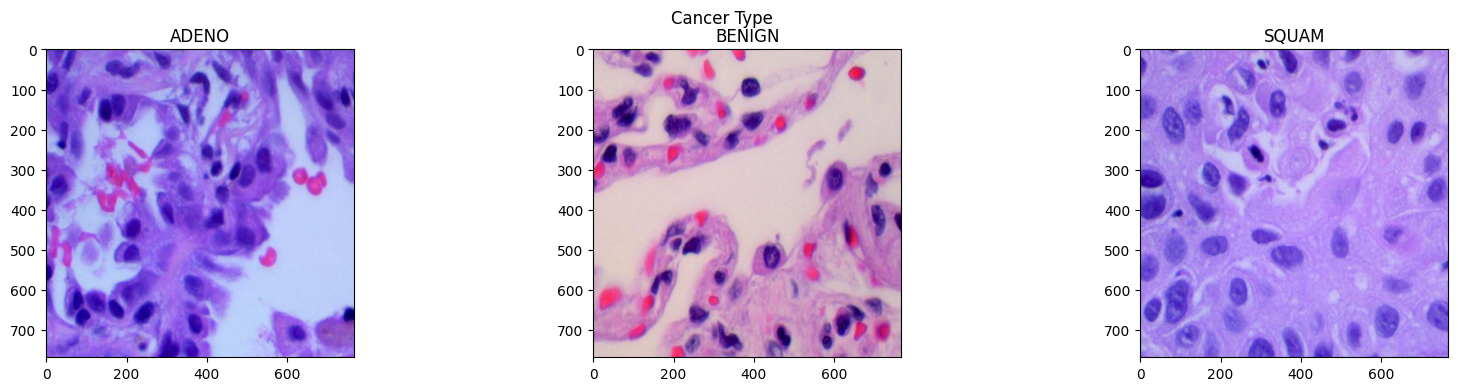

In [7]:
import random
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=len(img_label), figsize=(20,4))
fig.suptitle('Cancer Type')
random_num = random.randint(0,400)
for i,label in enumerate(img_label):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df[df['label']==label]['img'].iloc[random_num]))

In [8]:
plt.imread(df['img'][0]).shape

(768, 768, 3)

In [9]:
# Create a dataframe for mapping label
df_labels = {
    'ADENO' : 0,
    'BENIGN' : 1,
    'SQUAM' : 2,
}
# Encode
df['encode_label'] = df['label'].map(df_labels)
df.head()

,img,label,encode_label
0,C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1.jpeg,ADENO,0
1,C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca10.jpeg,ADENO,0
2,C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca100.jpeg,ADENO,0
3,C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1000.jpeg,ADENO,0
4,C:/Users/ocapo/Desktop/histopathology-dataset/lc25000_dataset/lung_colon_image_set/lung_image_sets/ADENO/lungaca1001.jpeg,ADENO,0


In [10]:
import cv2
import numpy as np
import pandas as pd

batch_size = 128  # Adjust as needed
X = []
with tf.device('/GPU:0'):
    for i in range(0, len(df), batch_size):
        batch_paths = df['img'].iloc[i:i+batch_size]
        batch_images = [cv2.imread(str(img)) for img in batch_paths]
        batch_images = [cv2.resize(img, (128,128)) for img in batch_images]
        batch_images = [img / 255 for img in batch_images]
        X.extend(batch_images)

In [11]:
y = df['encode_label']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [13]:
from keras.applications.densenet import DenseNet201

base_model = DenseNet201(input_shape=(128,128,3), include_top=False, weights='imagenet')

base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [14]:
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [15]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

learnRate = Adam(learning_rate=0.00001)
model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(img_label), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dropout (Dropout)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 256)               7864576   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 26,187,331
Trainable params: 7,906,051
Non

In [16]:
model.compile(
  optimizer=learnRate,
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

with tf.device('/GPU:0'):
  history = model.fit(np.array(X_train), np.array(y_train), epochs=70, validation_data=(np.array(X_val), np.array(y_val)))

Epoch 1/70
352/352 [==============================] - 59s 124ms/step - loss: 0.4916 - acc: 0.8155 - val_loss: 0.1335 - val_acc: 0.9574
Epoch 2/70
352/352 [==============================] - 41s 115ms/step - loss: 0.2274 - acc: 0.9156 - val_loss: 0.1068 - val_acc: 0.9606
Epoch 3/70
352/352 [==============================] - 41s 116ms/step - loss: 0.1846 - acc: 0.9309 - val_loss: 0.0921 - val_acc: 0.9659
Epoch 4/70
352/352 [==============================] - 41s 115ms/step - loss: 0.1471 - acc: 0.9417 - val_loss: 0.0842 - val_acc: 0.9648
Epoch 5/70
352/352 [==============================] - 40s 115ms/step - loss: 0.1359 - acc: 0.9461 - val_loss: 0.0874 - val_acc: 0.9638
Epoch 6/70
352/352 [==============================] - 41s 117ms/step - loss: 0.1244 - acc: 0.9524 - val_loss: 0.0731 - val_acc: 0.9744
Epoch 7/70
352/352 [==============================] - 41s 117ms/step - loss: 0.1094 - acc: 0.9553 - val_loss: 0.0674 - val_acc: 0.9797
Epoch 8/70
352/352 [==============================] - 4

In [17]:
with tf.device('/GPU:0'):
    model.evaluate(np.array(X_test),np.array(y_test))

88/88 [==============================] - 14s 157ms/step - loss: 0.0106 - acc: 0.9961


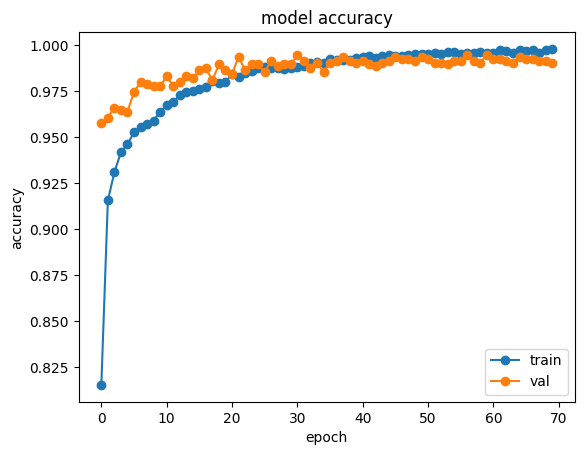

In [18]:
plt.plot(history.history['acc'], marker='o')
plt.plot(history.history['val_acc'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

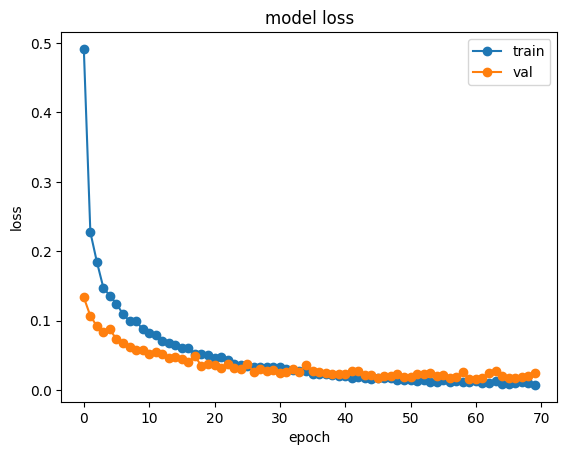

In [19]:
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()